In [15]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import requests
import os
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')
import json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
tng_api_key = userdata.get('TNG_API_KEY')
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":tng_api_key}

In [9]:
def get(path, params=None, out_filename=None):
    headers = {"api-key":tng_api_key}
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()

    if out_filename is not None:
        with open(out_filename, 'wb') as f:
            f.write(r.content)
        return out_filename

    if r.headers['content-type'] == 'application/json':
        return r.json()

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename

    return r

In [10]:
r = get(baseUrl)

for simulation in r['simulations']: #only get TNG50
    if simulation['name'] == 'TNG50-1':
        url = simulation['url']
        break

tng50 = get(url)

url = 'http://www.tng-project.org/api/TNG50-1/snapshots/z=1.8/'
snapshot = get(url)
snapshot.keys()

dict_keys(['simulation', 'number', 'redshift', 'num_gas', 'num_dm', 'num_trmc', 'num_stars', 'num_bhs', 'num_groups_fof', 'num_groups_subfind', 'num_groups_rockstar', 'filesize_snapshot', 'filesize_groupcat', 'filesize_rockstar', 'url', 'subhalos', 'vis', 'files'])

In [11]:
snapshot['num_groups_subfind']

7473304

In [14]:
drive_path = '/content/drive/MyDrive/docs'
os.makedirs(drive_path, exist_ok=True)

bhmdot = np.zeros(snapshot['num_groups_subfind'])
sfr = np.zeros(snapshot['num_groups_subfind'])

for i in range(35000):
    print(i)
    out_filename = os.path.join(drive_path, f'sub{i}.json')

    if os.path.exists(out_filename):
        print(f"File {out_filename} already exists, skipping.")
        continue

    sub_url = f"http://www.tng-project.org/api/TNG50-1/snapshots/{snapshot['number']}/subhalos/{i}/"
    try:
        result = get(sub_url, out_filename=out_filename)
        if result == out_filename and os.path.exists(out_filename):
            print(f"Successfully saved {out_filename}")
        else:
            print(f"Failed to save {out_filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading subhalo {i}: {e}")

Streaming output truncated to the last 5000 lines.
32500
File /content/drive/MyDrive/docs/sub32500.json already exists, skipping.
32501
File /content/drive/MyDrive/docs/sub32501.json already exists, skipping.
32502
File /content/drive/MyDrive/docs/sub32502.json already exists, skipping.
32503
File /content/drive/MyDrive/docs/sub32503.json already exists, skipping.
32504
File /content/drive/MyDrive/docs/sub32504.json already exists, skipping.
32505
File /content/drive/MyDrive/docs/sub32505.json already exists, skipping.
32506
File /content/drive/MyDrive/docs/sub32506.json already exists, skipping.
32507
File /content/drive/MyDrive/docs/sub32507.json already exists, skipping.
32508
File /content/drive/MyDrive/docs/sub32508.json already exists, skipping.
32509
File /content/drive/MyDrive/docs/sub32509.json already exists, skipping.
32510
File /content/drive/MyDrive/docs/sub32510.json already exists, skipping.
32511
File /content/drive/MyDrive/docs/sub32511.json already exists, skipping.
3

In [16]:
bhl = []
sfrl = []

for i in range(35000):
    file_path = os.path.join(drive_path, f'sub{i}.json')
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                sub_data = json.load(f)
            bhl.append(sub_data.get('bhmdot', 0.0))
            sfrl.append(sub_data.get('sfr', 0.0))
        except json.JSONDecodeError:
            print(f"Error decoding JSON from {file_path}. Skipping.")
    else:
        print(f"File {file_path} not found. Skipping.")

print(f"Collected {len(bhl)} bhmdot entries and {len(sfrl)} sfr entries.")

Collected 35000 bhmdot entries and 35000 sfr entries.


In [17]:
counts1, bin_edges = np.histogram(bhl)
counts2, bin_edges = np.histogram(sfrl)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

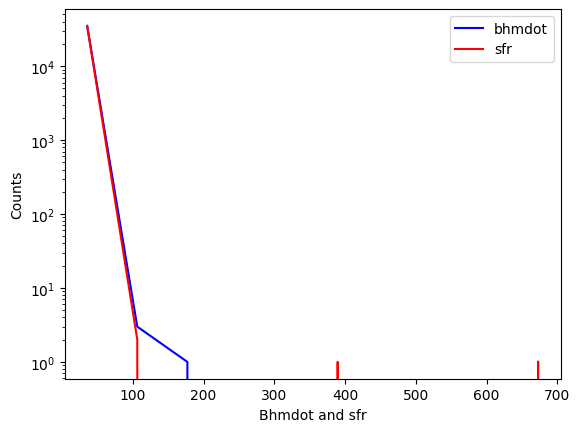

In [19]:
plt.plot(bin_centers, counts1, label='bhmdot', color='blue')
plt.plot(bin_centers, counts2, label='sfr', color='red')
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Bhmdot and sfr')
plt.legend()
plt.show()